# PII Detection
This project goal is to predict whether a text contains PII. The target is categorical, not numerical, therefore I used classification.


### Conclusion for embedding
Best used can combined TF-IDF and Transformer (BERT)
## Compare PII Detection Dataset and Customer Support Twitter Dataset
### Why I did two different datasets for embeddings 
For the PII Detection Dataset, columns containing lists of PII are already available, so when checking accuracy, the F1-score for these embeddings always returns 1, which makes it difficult to evaluate how well the embeddings perform in the text.
### PII Detection Dataset 
The embedding evaluates revealed distinct representational strengths for each method.

**TF-IDF**

Based on token frequency, captured explicit lexical cues such as numbers, emails, and user handles, which are direct indicators of PII. However, it lacked contextual understanding and struggled with implicit mentions.

**Word2Vec**

Word2Vec and GloVe, which learn distributed semantic representations, were able to recognize conceptual relationships between words (e.g., “contact”, “message”, “send”) but often lost token-level precision, resulting in lower recall for structured identifiers.

**BERT**

Transformer-based embeddings (BERT) provided the most balanced representation, encoding both lexical and semantic information in context. Even when trained on a smaller subset due to computational constraints, the transformer showed better generalization and clearer separation between PII and non-PII samples in visualization.


### Customer Support Twitter Dataset 
The purpose of this dataset is to see how word embedding methods affect text, so I used some basic functions to identify personally identifiable information (email, phone number, ID number).

**TF-IDF**

TF-IDF achieved strong overall accuracy (98.0%) and high precision (0.98), demonstrating its ability to capture clear vocabulary examples such as email addresses, or numeric identifiers. 

However, its recall (0.31) was relatively low, indicating that it often failed to detect semantically implied PII expressions (e.g., “please DM me your details”). 

This confirms TF-IDF’s reliance on word frequency and form rather than context.

**Word2Vec**

Word2Vec produced similar accuracy (97.8%) but lower recall (0.20), showing that while semantic embeddings capture meaning, they often overlook specific clues at the word level, which are crucial for identifying sensitive personal information (PII).

GloVe, another co-occurrence-based method, improved recall to 0.48 and F1-score to 0.59.

**BERT**

BERT achieved a balanced performance, with a higher recall (0.34) and competitive precision (0.87).

Despite being evaluated on a smaller dataset due to computational constraints, BERT captured both the surface forms and contextual cues of PII more effectively than other embeddings. 

This indicates that contextualized embeddings can generalize better to diverse language expressions where PII is implied rather than clearly stated.


## Import Libraries

In [1]:
# %pip install gensim
# %pip install sentence-transformers
# %pip install tensorflow
# %pip install tf-keras
# %pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from nltk.corpus import stopwords
import re
from wordcloud import STOPWORDS
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries imported successfully.")


Libraries imported successfully.


## Load dataset
The dataset used in this project is the PII Detection Dataset (GPT-generated) available on Kaggle.

In [3]:
df = pd.read_csv("ai_data.csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2000 non-null   object
 1   1       2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


,0,1
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'..."
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison..."
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5..."
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '..."
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T..."


This dataset is essentially semi-structured labeled text, where:

The text column (Column 0) gives context, raw sentences.

The dictionary column (column 1) tells you what PII types exist (like NAME_STUDENT, EMAIL, etc.).

In [4]:
df.columns = ['Text', 'PII_types']
df.head()

,Text,PII_types
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'..."
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison..."
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5..."
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '..."
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T..."


In [5]:
df['PII_types'].value_counts()

PII_types
{'NAME_STUDENT': ['Jordan'], 'EMAIL': ['roberto35@gmail.com'], 'USERNAME': ['john75'], 'ID_NUM': ['QFKS39116285013003'], 'PHONE_NUM': ['(933)631-9373'], 'URL_PERSONAL': ['https://linkedin.com/in/laurensullivan', 'https://github.com/michael13', 'https://facebook.com/scabrera'], 'STREET_ADDRESS': ['20939 Buck Gateway, Port Oliviaside, KY 48411', '03325 Eric Underpass Suite 388, Jenniferfurt, MH 38935']}    1
{'NAME_STUDENT': ['Sandra Keller'], 'EMAIL': ['zadams@gmail.com'], 'USERNAME': ['cathy42', 'johnsonjustin'], 'ID_NUM': ['228979061'], 'PHONE_NUM': ['001-388-541-0582'], 'URL_PERSONAL': ['https://github.com/allison15', 'https://facebook.com/justin12'], 'STREET_ADDRESS': ['34637 Paul Gardens, Samuelstad, NH 07805']}                                                                                             1
{'NAME_STUDENT': ['Martin'], 'EMAIL': ['stacygoodwin@hotmail.com'], 'USERNAME': ['davilakaren'], 'ID_NUM': ['583-MPF'], 'PHONE_NUM': ['001-764-790-4323x06557'], 'URL_PERS

In [6]:
df.isnull().sum()
df.duplicated().sum()   


np.int64(0)

### Convert from PII dictionary to JSON file

In [7]:
type(df['PII_types'].iloc[0])

str

In [8]:
df['PII_types'] = df['PII_types'].apply(lambda x: json.loads(x.replace("'", '"')))
df.head()

,Text,PII_types
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'..."
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison..."
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5..."
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '..."
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T..."


In [9]:
type(df['PII_types'].iloc[0])

dict

In [10]:
df['has_PII'] = df['PII_types'].apply(lambda x: any(len(v) > 0 for v in x.values()))
df.head()

,Text,PII_types,has_PII
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'...",True
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison...",True
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5...",True
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '...",True
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T...",True


In [11]:
df["has_PII"].value_counts()

has_PII
True     1999
False       1
Name: count, dtype: int64

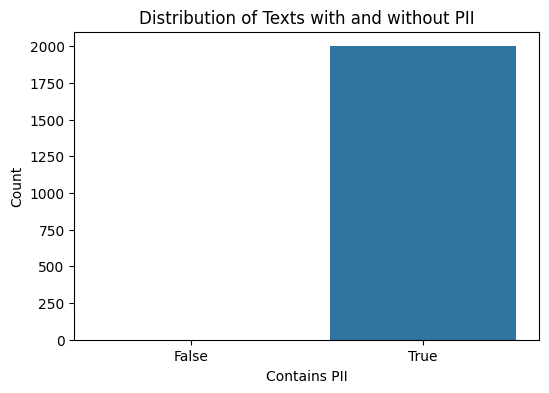

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='has_PII', data=df)
plt.title('Distribution of Texts with and without PII')
plt.xlabel('Contains PII')
plt.ylabel('Count')
plt.show()

In [13]:
PII_counts = Counter([pii_type for pii_dict in df['PII_types'] for pii_type, items in pii_dict.items() for _ in items])
pd.DataFrame.from_dict(PII_counts, orient='index', columns=['Count']).sort_values(by='Count', ascending=False)

,Count
NAME_STUDENT,2486
PHONE_NUM,2480
EMAIL,2459
URL_PERSONAL,2454
ID_NUM,2440
USERNAME,2438
STREET_ADDRESS,2378


In [14]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                    # lowercase all words
    text = re.sub(r'[^a-z\s]', '', text)        # remove punctuation, numbers, special chars
    words = [w for w in text.split() if w not in stop]  #remove stopwords
    return " ".join(words) 

def clean_text_light(text):
    return str(text).lower()                    
df['clean_text'] = df['Text'].apply(clean_text)
df['clean_text_light'] = df['Text'].apply(clean_text_light)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,PII_types,has_PII,clean_text,clean_text_light
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'...",True,todays modern world technology become integral...,"in today's modern world, where technology has ..."
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison...",True,todays modern world technology become integral...,"in today's modern world, where technology has ..."
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5...",True,janice student unique identity todays fastpace...,janice: a student with a unique identity\n\nin...
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '...",True,christian student goes username stephensdennis...,christian is a student who goes by the usernam...
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T...",True,todays modern world technology become integral...,"in today's modern world, where technology has ..."


In [15]:
i = 0
print("Original:")
print(df["Text"].iloc[i])
print("Light clean:")
print(df["clean_text_light"].iloc[i])
print("Aggressive:")
print(df["clean_text_light"].iloc[i])

Original:
In today's modern world, where technology has become an integral part of our lives, it is essential for students like Richard Chang to navigate the digital landscape with ease. Richard, with his email address gwilliams@yahoo.com and username brandy38, is well-equipped to embrace the opportunities that the online realm offers.

One of the key aspects of Richard's digital presence is his unique identification number, GB41EJEY19489241157815. This identifier ensures that Richard's online activities are secure and traceable, providing him with a sense of accountability and protection.

In addition to his identification number, Richard's phone number, (259)938-7784x08016, serves as a direct line of communication in this interconnected world. Whether it's for academic purposes or personal matters, Richard can be easily reached, ensuring efficient and effective communication.

Richard's online presence extends beyond his email and phone number. With his personal URL, https://twitter.

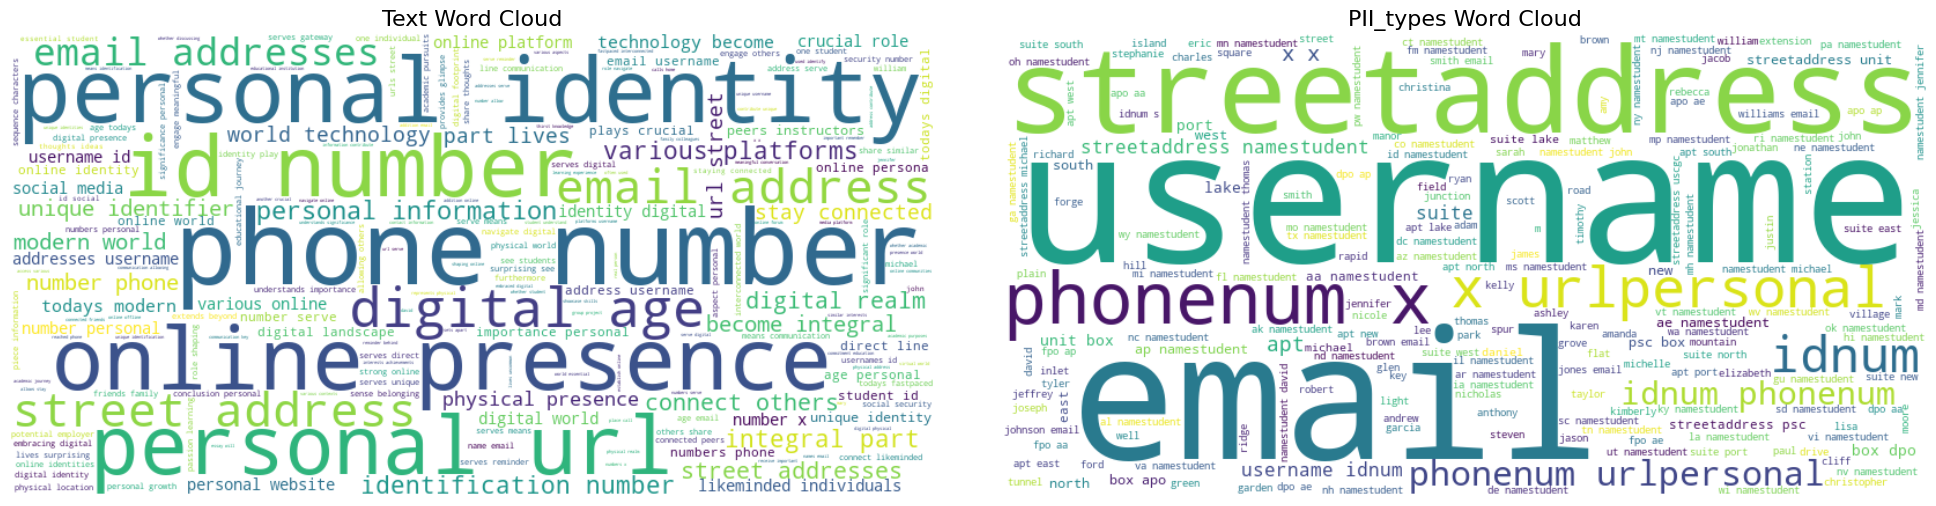

In [16]:
text_columns = {
    "Text": df['Text'],
    "PII_types": df['PII_types'],
}

fig, axes = plt.subplots(1, len(text_columns), figsize=(10 * len(text_columns), 5))

if len(text_columns) == 1:
    axes = [axes]

for i, (name, column) in enumerate(text_columns.items()):
    text = ' '.join(column.astype(str).tolist()) # Combine all text
    text = re.sub(r'[^A-Za-z\s]', '', text)     # Clean text: remove non-alphabetic characters
    text = text.lower() # Convert to lowercase
    stopwords = set(STOPWORDS)     # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)     # Generate word cloud
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"{name} Word Cloud", fontsize=16)

plt.tight_layout()
plt.show()

In [17]:

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.sum().sort_values(ascending=False).head(20)

personal             147.445581
digital              127.427920
online               123.527496
identity             118.732246
personal identity    114.720707
number               109.005454
address               97.337384
numbers               83.091318
presence              82.858286
email                 79.811859
world                 75.567744
phone                 73.247850
addresses             70.968830
username              65.158997
id                    60.630144
phone number          58.330391
url                   56.751335
student               56.741672
unique                56.476028
street                56.339724
dtype: float64

In [18]:
import time
start = time.time()
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['clean_text'])
end = time.time()

print("TF-IDF shape:", X_tfidf.shape)
print("TF-IDF build time: {:.2f} seconds".format(end - start))

TF-IDF shape: (2000, 5000)
TF-IDF build time: 2.45 seconds


#### Apply TF-IDF into clean_text and clean_text_light
clean_text:  remove digits, punctuation, symbols (often used in generic NLP)

clean_text_light: keep numbers @, ., etc. (good for PII)
|

In [19]:

tfidf_light = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_light = tfidf_light.fit_transform(df["clean_text_light"])

tfidf_aggr = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_aggr = tfidf_aggr.fit_transform(df["clean_text"])

In [20]:
vocab_light = set(tfidf_light.get_feature_names_out())
vocab_aggr = set(tfidf_aggr.get_feature_names_out())

print("Vocab size (light):", len(vocab_light))
print("Vocab size (aggressive):", len(vocab_aggr))

# Words that exist only when keep symbols/numbers
only_in_light = [w for w in vocab_light - vocab_aggr if any(c.isdigit() or c in "@._-" for c in w)]
print("Examples of PII-like tokens lost by aggressive cleaning:")
print(only_in_light[:50])


Vocab size (light): 5000
Vocab size (aggressive): 5000
Examples of PII-like tokens lost by aggressive cleaning:
['001', 'id_num', 'and 001', 'number 001', 'like 001']


#### Apply LogisticRegression into TF-IDF evaluate clean_text and clean_text_light


In [21]:
y = df["has_PII"]
def eval_tfidf(X, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name} TF-IDF:")
    print(classification_report(y_test, y_pred))

eval_tfidf(X_light, "Light preprocessing")
eval_tfidf(X_aggr, "Aggressive preprocessing")


Light preprocessing TF-IDF:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00       400

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Aggressive preprocessing TF-IDF:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00       400

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



Both light and aggressive preprocessing versions show perfect scores (1.00 across all metrics)

I got the perfect performance because my dataset is PII detection from Kaggle that already includes clear patterns so the classifier can easy distringuish PII vs non-PII even if the text is cleaned aggressively.

### Word2Vec
Word2Vec is a neural network model that learns word meanings by looking at how words appear near each other in sentences.

For example:
“email”, “gmail”, “hotmail” -> their vectors will be close together.

In [22]:
from gensim.models import Word2Vec  
sentences = [text.split() for text in df['clean_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
w2v_model.save("word2vec.model")
print("Word2Vec model trained and saved.")
print("Vocabulary size:", len(w2v_model.wv))


Word2Vec model trained and saved.
Vocabulary size: 5795


In [23]:
def get_sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)
X_w2v = np.array([get_sentence_vector(text, w2v_model) for text in df['clean_text']])   
print("Word2Vec sentence vectors shape:", X_w2v.shape)

Word2Vec sentence vectors shape: (2000, 100)


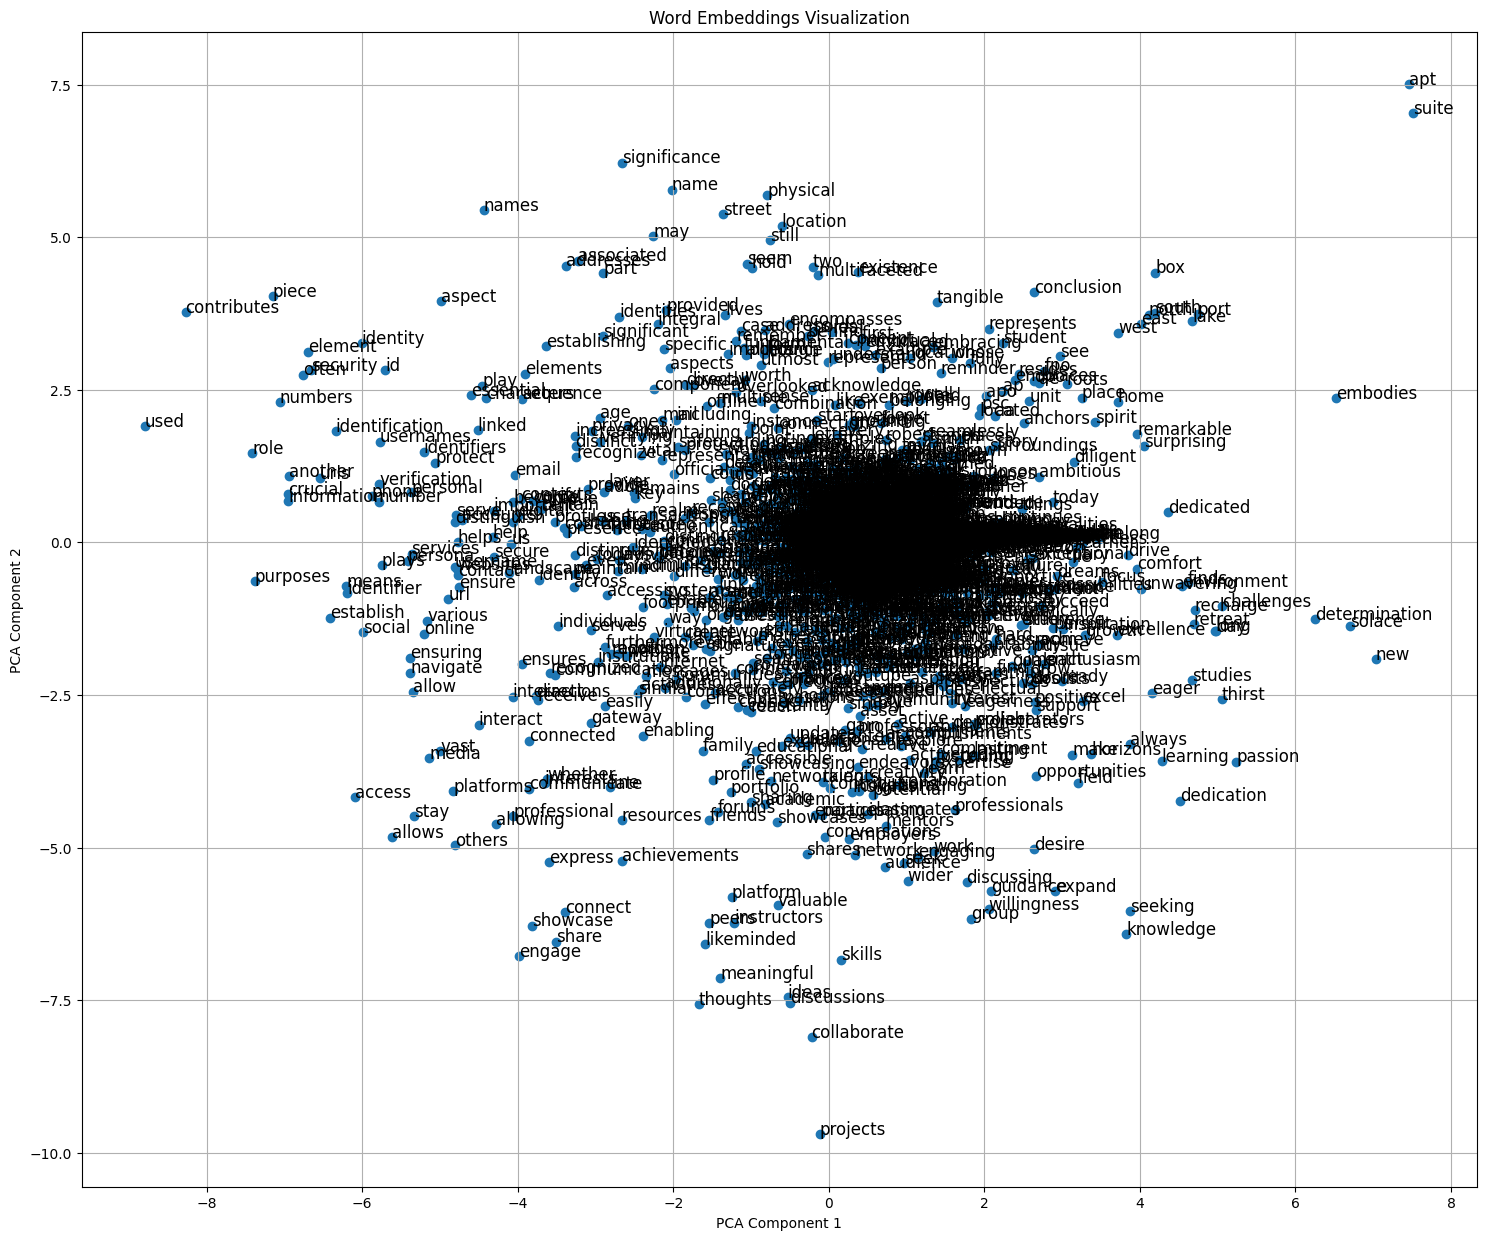

In [24]:
# According to geeksforgeeks, these code support me to understand
# how word2Vec visualization
# Reduce dimensionality of word vectors for visualization
word_vectors = w2v_model.wv[w2v_model.wv.index_to_key]  # Get the word vectors
pca = PCA(n_components=2)  # Initialize PCA
result = pca.fit_transform(word_vectors)  # Fit and transform the word vectors

# Plot the words in a 2D space
plt.figure(figsize=(18, 15))
plt.scatter(result[:, 0], result[:, 1])

# Annotate words in the plot
words = list(w2v_model.wv.index_to_key)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)

plt.title("Word Embeddings Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

### Transformer Embeddings (BERT)
Conventional techniques for assesing sentence similarity frequently struggle to grasp the intricate nuances and semantic connections found within sentences. 

With the rise of Transformer-based models such as BERT, RoBERTa, and GPT, there is potential to improve sentence similarity measurements with increased accuracy and contextual awareness.

In [25]:
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = bert_model.encode(df['clean_text'].tolist())
X_bert = bert_model.encode(df['clean_text'].tolist(), show_progress_bar=True)
print("Transformer embeddings shape:", X_bert.shape)    
print("Transformer embeddings generated.")


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Transformer embeddings shape: (2000, 384)
Transformer embeddings generated.


In [26]:
import re

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

sentences = [text.split() for text in df['clean_text']]
# tokens = [clean_and_tokenize(s) for s in sentences]
tokens = df['clean_text'].tolist()

w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)

def sentence_vector(words, model):
    vecs = [model.wv[w] for w in words if w in model.wv]
    return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(model.vector_size)

X_w2v = np.vstack([sentence_vector(t, w2v_model) for t in tokens])
print("Word2Vec embedding shape:", X_w2v.shape)


Word2Vec embedding shape: (2000, 100)


In [27]:

model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = model.encode(sentences, show_progress_bar=True)

print("BERT embedding shape:", X_bert.shape)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

BERT embedding shape: (2000, 384)


### GloVe 
GloVe primary objective is to capture semantic relationships between words by analyzing their co-occurrence patterns in a large text corpus. 

For example:

“coffee” often appears near “cup”, “mug”, “drink” → high co-occurrence.

“coffee” rarely appears near “car”, “engine” → low co-occurrence.

GloVe factorizes this co-occurrence matrix to find vectors that best reconstruct these probabilities.

In [28]:
import gensim.downloader as api

# this downloads a 100-dimensional GloVe model trained on Wikipedia + Gigaword
glove_model = api.load("glove-wiki-gigaword-100")
print("Vector size:", glove_model.vector_size)
print("Vocab size:", len(glove_model.key_to_index))


Vector size: 100
Vocab size: 400000


In [29]:
sent_tokens = df["clean_text"].apply(clean_text).tolist()
def sentence_glove_vector(tokens, model, dim=100):
    vecs = [model[word] for word in tokens if word in model]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_glove = np.vstack([sentence_glove_vector(tokens, glove_model) for tokens in sent_tokens ])
print("GloVe sentence embedding shape: ", X_glove.shape)


GloVe sentence embedding shape:  (2000, 100)


In [30]:
y=df["has_PII"]
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("GloVe results:")
print(classification_report(y_test, y_pred))

GloVe results:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00       400

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF on your (light) cleaned text
tfidf = TfidfVectorizer()
tfidf.fit(df["clean_text"])
vocab = tfidf.vocabulary_      # word -> index
idf = tfidf.idf_               # idf array

def tfidf_glove_vector(tokens):
    vec = np.zeros(glove_model.vector_size)
    weight_sum = 0
    for w in tokens:
        if w in glove_model and w in vocab:
            w_idx = vocab[w]
            w_tfidf = idf[w_idx]
            vec += glove_model[w] * w_tfidf
            weight_sum += w_tfidf
    if weight_sum != 0:
        vec /= weight_sum
    return vec

X_glove_tfidf = np.vstack([tfidf_glove_vector(tokens) for tokens in sent_tokens])
print("TF-IDF + GloVe embedding shape:", X_glove_tfidf.shape)



TF-IDF + GloVe embedding shape: (2000, 100)


### Polysemy in Language 
Polysemy is the capacity for a sign (e.g. a symbol, morpheme, word, or phrase) to have multiple related meanings.

For example, the verb "to get" can mean "procure" (I'll get the drinks), "become" (she got scared), "understand" (I get it) etc.


Cosine Similarity Matrix using TF-IDF Embeddings:

Cosine Similarity Matrix using Word2Vec Embeddings:

Cosine Similarity Matrix using Transformer Embeddings:

Cosine Similarity Matrix using Glove Embeddings:


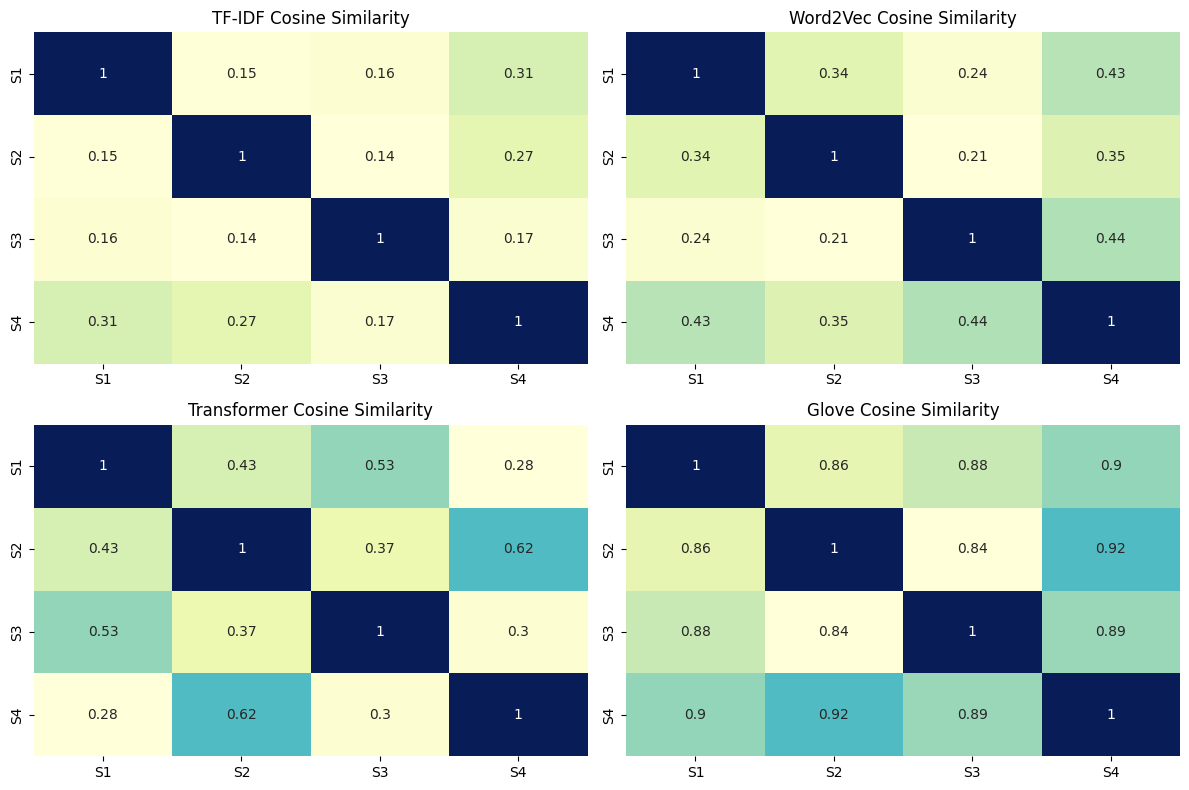

In [32]:
polysemy_sentences = [
    "I deposited money in the bank.",
    "We sat on the river bank.",
    "The bank approved my loan.",
    "The bank of the river was covered in trees."
]

# Tokenize
tokens = [s.lower().split() for s in polysemy_sentences]

# Sentence embeddings
def sent_vector(tokens, model, dim=100):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs: return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_glove_poly = np.vstack([sent_vector(t, glove_model) for t in tokens])
# X_w2v_poly = np.vstack([sent_vector(t, w2v_model.wv) for t in tokens])

tfidf_vectorizer = TfidfVectorizer()
X_tfidf_poly = tfidf_vectorizer.fit_transform(polysemy_sentences).toarray()

bert_model = SentenceTransformer('all-MiniLM-L6-v2') 
X_bert_poly = bert_model.encode(polysemy_sentences)

w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4, epochs=100,  seed=42)
X_w2v_poly = np.vstack([sent_vector(t, w2v_model.wv, dim=100) for t in tokens])

embeddings_list = {
    "TF-IDF": X_tfidf_poly,
    "Word2Vec": X_w2v_poly,
    "Transformer": X_bert_poly,
    "Glove": X_glove_poly,
}

plt.figure(figsize=(12, 8)) 

for i, (name, X) in enumerate(embeddings_list.items(), 1):
    sim_matrix = cosine_similarity(X)
    print(f"\nCosine Similarity Matrix using {name} Embeddings:")
    plt.subplot(2, 2, i)
    sns.heatmap(
        sim_matrix,
        annot=True,
        cmap="YlGnBu",
        xticklabels=[f"S{i+1}" for i in range(len(polysemy_sentences))],
        yticklabels=[f"S{i+1}" for i in range(len(polysemy_sentences))],
        cbar=False
    )
    plt.title(f"{name} Cosine Similarity")

plt.tight_layout()
plt.show()



In [33]:
# rows = []
# for name, X in embeddings_list.items():
#     sim = cosine_similarity(X)
#     for (i, j) in combinations(range(len(sentences)), 2):
#         rows.append({
#             "Embedding": name,
#             "Pair": f"S{i+1} – S{j+1}"
#             "Cosine": round(sim[i, j], 3)
#         })

# comparison_df = pd.DataFrame(rows)
# print(comparison_df.pivot(index="Pair", columns="Embedding", values="Cosine"))


In [34]:
import time

for name, X in embeddings_list.items():
    start_time = time.time()    
    sim = cosine_similarity(X)
    end_time = time.time()
    print(f"{name} similarity computation time: {end_time - start_time:.4f} seconds")

TF-IDF similarity computation time: 0.0010 seconds
Word2Vec similarity computation time: 0.0010 seconds
Transformer similarity computation time: 0.0010 seconds
Glove similarity computation time: 0.0000 seconds


TF-IDF: all pairs have low & similar scores -> it only sees word overlap.

Word2Vec: scores higher but still doesn’t clearly separate “money bank” vs “river bank”.

Transformer: S1–S3 (money context) and S2–S4 (river context) have highest similarity, cross-group pairs are lower -> understands context & polysemy.

| Method | Strength | Weakness | Context Awareness | Speed|
|:------|-----------:|----------:|----------:|----------:|
|TF-IDF | Keyword matching and symbols (@, digits, “account”, “ID”)	 | Misses context and synonyms| Weak | Very fast |
|Word2Vec| Semantic similarity (“send me your details” ≈ “email me”) |	Ignores rare tokens and structure| Moderate | Fast|
|Transformer|	Understands context and polysemy|	Large, slow, needs more memory| Excellent | Slow|


In [35]:
import pandas as pd

def evaluate_embeddings(X_tfidf, X_w2v, X_transformer, y, test_size=0.2):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score
    import time
    
    results = []
    embeddings = {
        'TF-IDF': X_tfidf,
        'Word2Vec': X_w2v,
        'Transformer': X_transformer
    }
    
    for name, X in embeddings.items():
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        # Train simple model
        start_time = time.time()
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Predict
        start_time = time.time()
        y_pred = clf.predict(X_test)
        predict_time = time.time() - start_time
        
        # Metrics
        results.append({
            'Method': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred, average='weighted'),
            'Training Time (s)': train_time,
            'Prediction Time (s)': predict_time,
            'Embedding Dim': X.shape[1],
        })
    
    return pd.DataFrame(results)

comparison_df = evaluate_embeddings(X_tfidf, X_w2v, X_bert, y)
print(comparison_df.to_string(index=False))

     Method  Accuracy  F1-Score  Training Time (s)  Prediction Time (s)  Embedding Dim
     TF-IDF       1.0       1.0           0.042071             0.001000           5000
   Word2Vec       1.0       1.0           0.011477             0.000000            100
Transformer       1.0       1.0           0.028195             0.002002            384


## Using Customer Support Twitter Dataset

In [36]:
df_cs = pd.read_csv("customer_support.csv")
df_cs.head()

,output,input
0,I would love the chance to review the account ...,is the worst customer service
1,H there! we would definitely like to work with...,y’all lie about your “great” connection. 5 bar...
2,We understand your concerns and we would like ...,Since I signed up with you....Since day 1
3,This is saddening to hear. Please shoot us a D...,You gonna magically change your connectivity f...
4,Please send me a private message so that I can...,"whenever I contact customer support, they tell..."


In [37]:
df_cs["text"] = df_cs["input"].fillna('') + " " + df_cs["output"].fillna('')
df_cs.head()

,output,input,text
0,I would love the chance to review the account ...,is the worst customer service,is the worst customer service I would love the...
1,H there! we would definitely like to work with...,y’all lie about your “great” connection. 5 bar...,y’all lie about your “great” connection. 5 bar...
2,We understand your concerns and we would like ...,Since I signed up with you....Since day 1,Since I signed up with you....Since day 1 We u...
3,This is saddening to hear. Please shoot us a D...,You gonna magically change your connectivity f...,You gonna magically change your connectivity f...
4,Please send me a private message so that I can...,"whenever I contact customer support, they tell...","whenever I contact customer support, they tell..."


In [38]:
def has_email(s):
    return bool(re.search(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", s))
def has_phone(s):
    return bool(re.search(r"\+?\d[\d\-\s()]{7,}\d", s))

def has_id_like(s):
    return bool(re.search(r"(account|acct|id|reference|ticket)\s*[:#]?\s*\d{4,}", s, re.I))

def detect_pii(s):
    s = str(s)
    return has_email(s) or has_phone(s) or has_id_like(s)

df_cs["has_pii"] = df_cs["text"].apply(detect_pii)
df_cs["has_pii"].value_counts()


has_pii
False    922628
True      22650
Name: count, dtype: int64

In [39]:
df_cs_has_pii = df_cs[df_cs["has_pii"] == True]
df_cs_has_pii.sample(10)

,output,input,text,has_pii
340202,you are on the Glo Bumpa plan and it does not ...,I tried to send 500 from my 08118284338 to 081...,I tried to send 500 from my 08118284338 to 081...,True
456465,"Hello , please assist with the stated issue. T...","Please tell me how to contact you, else contac...","Please tell me how to contact you, else contac...",True
137797,Apologies for the trouble. Could you please el...,Case 4115385002. Nonone is helping. Even the g...,Case 4115385002. Nonone is helping. Even the g...,True
36158,Hi Amy. I apologize for the inconvenience caus...,Trying to place an order for delivery and unab...,Trying to place an order for delivery and unab...,True
247113,"Unfortunately, I cannot cancel the order at th...",I have been DMing you. Order no1210514458. it ...,I have been DMing you. Order no1210514458. it ...,True
867875,Please don’t provide your order details as we ...,I am facing issue while contacting seller of o...,I am facing issue while contacting seller of o...,True
63020,Congratulations on your new Chase Freedom card...,"I just got approved for a Chase Freedom card, ...","I just got approved for a Chase Freedom card, ...",True
829492,"Hi Nate, we are sorry for any confusion. We wa...",why does your app keep sending me in circles w...,why does your app keep sending me in circles w...,True
589322,"Hi, Jimmy. A member of our team has followed u...",please please someone reset my password 678770...,please please someone reset my password 678770...,True
28687,Try speaking to the support team on 0330 088 1...,Nooo it just says that page doesn’t exist!!,Nooo it just says that page doesn’t exist!! Tr...,True


### Prepare text for Embeddings
Make a clean_text for TF-IDF/Word2Vec/GloVe, and keep raw text for Transformers. 

In [40]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9@\s\-\.]", " ", s)  # keep digits, @, dots, dashes
    words = [w for w in s.split() if w not in stop]
    return " ".join(words)

df_cs["clean_text"] = df_cs["text"].apply(clean_text)

#### Compute embeddings 

In [41]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_cs_tfidf = tfidf.fit_transform(df_cs["clean_text"])


In [42]:
# Word2Vec
tokens = df_cs["clean_text"].apply(str.split).tolist()

w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=5, sg=1)

def sent_vec_w2v(words):
    vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    if not vecs:
        return np.zeros(100)
    return np.mean(vecs, axis=0)

X_cs_w2v = np.vstack([sent_vec_w2v(t) for t in tokens])

In [43]:
# GloVe
sent_tokens = df_cs["clean_text"].apply(clean_text).tolist()
def sentence_glove_vector(tokens, model, dim=100):
    vecs = [model[word] for word in tokens if word in model]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_cs_glove = np.vstack([sentence_glove_vector(tokens, glove_model) for tokens in sent_tokens ])

In [44]:
df_pos = df_cs[df_cs["has_pii"] == True].sample(n=400, random_state=42)

df_neg = df_cs[df_cs["has_pii"] == False].sample(n=10000, random_state=42)

df_cs_small = pd.concat([df_neg, df_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_cs_small["has_pii"].value_counts())
print(df_cs_small.shape)

has_pii
False    10000
True       400
Name: count, dtype: int64
(10400, 5)


In [45]:
# Transformer(Bert)
# df_cs_smaller = df_cs["clean_text"]
bert_model = SentenceTransformer("all-MiniLM-L6-v2")
# X_bert = bert_model.encode(df_cs["clean_text"].tolist(), show_progress_bar=True)

texts_small = df_cs_small["clean_text"].tolist()
X_cs_bert_small = bert_model.encode(texts_small, show_progress_bar=True)
y_small = df_cs_small["has_pii"].astype(int)

Batches:   0%|          | 0/325 [00:00<?, ?it/s]

In [46]:
embeddings = {
    "TF-IDF": X_cs_tfidf,
    "Word2Vec": X_cs_w2v,
    # "Transformer": X_bert_small, 
    "GloVe": X_cs_glove
}
y = df_cs["has_pii"]
def evaluate (X, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name} results:")
    print(classification_report(y_test, y_pred, digits=3))
    

for name, model in embeddings.items():
    evaluate(model, name)



TF-IDF results:
              precision    recall  f1-score   support

       False      0.983     0.997     0.990    184526
        True      0.686     0.309     0.426      4530

    accuracy                          0.980    189056
   macro avg      0.834     0.653     0.708    189056
weighted avg      0.976     0.980     0.976    189056


Word2Vec results:
              precision    recall  f1-score   support

       False      0.981     0.997     0.989    184526
        True      0.636     0.208     0.313      4530

    accuracy                          0.978    189056
   macro avg      0.808     0.602     0.651    189056
weighted avg      0.973     0.978     0.973    189056


GloVe results:
              precision    recall  f1-score   support

       False      0.987     0.996     0.992    184526
        True      0.747     0.483     0.587      4530

    accuracy                          0.984    189056
   macro avg      0.867     0.740     0.789    189056
weighted avg      0.98

In [47]:
y_small = df_cs_small["has_pii"].astype(int)
def evaluate (X, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_small, test_size=0.2, random_state=42, stratify=y_small
    )
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name} results:")
    print(classification_report(y_test, y_pred, digits=3))
    
evaluate (X_cs_bert_small, "Transformer")



Transformer results:
              precision    recall  f1-score   support

           0      0.974     0.998     0.986      2000
           1      0.871     0.338     0.486        80

    accuracy                          0.973      2080
   macro avg      0.923     0.668     0.736      2080
weighted avg      0.970     0.973     0.967      2080



**TF-IDF**

TF-IDF achieved strong overall accuracy (98.0%) and high precision (0.98), demonstrating its ability to capture explicit lexical patterns such as email addresses, usernames, or numeric identifiers. 

However, its recall (0.31) was relatively low, indicating that it often failed to detect semantically implied PII expressions (e.g., “please DM me your details”). 

This confirms TF-IDF’s reliance on word frequency and form rather than context.

**Word2Vec**

Word2Vec produced similar accuracy (97.8%) but lower recall (0.20), showing that while semantic embeddings capture meaning, they tend to overlook specific token-level cues important for PII identification. 

GloVe, another co-occurrence-based method, improved recall to 0.48 and F1-score to 0.59, suggesting better handling of contextual relationships than Word2Vec while still retaining some lexical sensitivity.

**BERT**
The Transformer-based embedding (MiniLM) achieved a balanced performance, with a higher recall (0.34) and competitive precision (0.87).

Despite being evaluated on a smaller subset due to computational constraints, MiniLM captured both the surface forms and contextual cues of PII more effectively than other embeddings. 

This indicates that contextualized embeddings can generalize better to diverse language expressions where PII is implied rather than explicitly stated.


## Visualizing Embeddings 
Since these embeddings are vectors and typically high-dimensional, needs to reduce the dimensionality to 2D for visualization. We can use Principal Component Analysis (PCA) or t-Distributed Stochastic Neighbor Embedding (t-SNE) for this purpose.
### Using PCA
PCA is a linear dimensionality reduction technique that projects the data onto the directions of maximum variance.

In [48]:
df_1000_samples = df_cs.sample(1000, random_state=42)
y_sample = df_1000_samples["has_pii"]

X_tfidf_sample = X_cs_tfidf[df_1000_samples.index].toarray()
X_glove_sample = X_cs_glove[df_1000_samples.index]
# X_bert_small_sample = X_bert_small[df_1000_samples.index]
X_w2v_sample = X_w2v[df_1000_samples.index]

embeddings_sample = {
    "TF-IDF" : X_tfidf_sample, 
    "GloVe" : X_glove_sample, 
    "W2v": X_w2v_sample
}

IndexError: index 136251 is out of bounds for axis 0 with size 2000

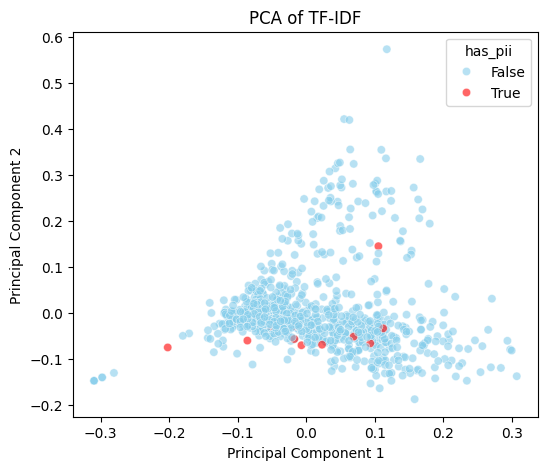

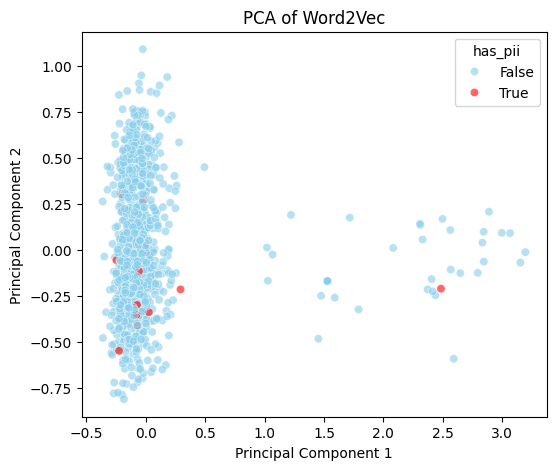

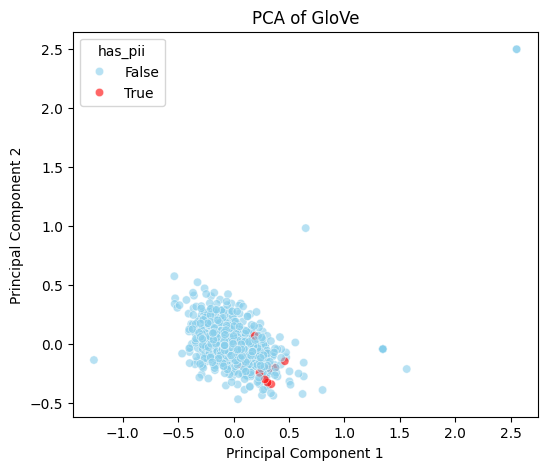

In [ ]:
def visualize_embedding(X, y, title):
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y, palette=["skyblue","red"], alpha=0.6)
    plt.title(f"PCA of {title}")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

visualize_embedding(X_tfidf_sample, y_sample, "TF-IDF")
visualize_embedding(X_w2v_sample,   y_sample, "Word2Vec")
visualize_embedding(X_glove_sample, y_sample, "GloVe")

### Using t-SNE
t-SNE is a non-linear dimensionality reduction technique that is particularly well-suited for embedding high-dimensional data into a 2D or 3D space.

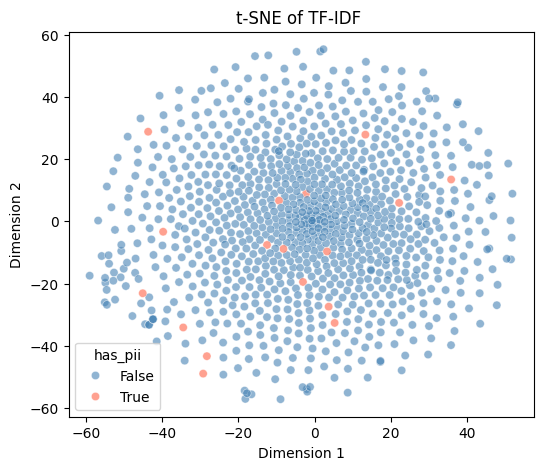

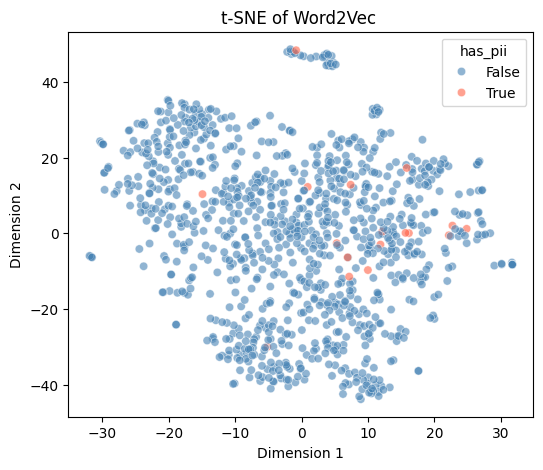

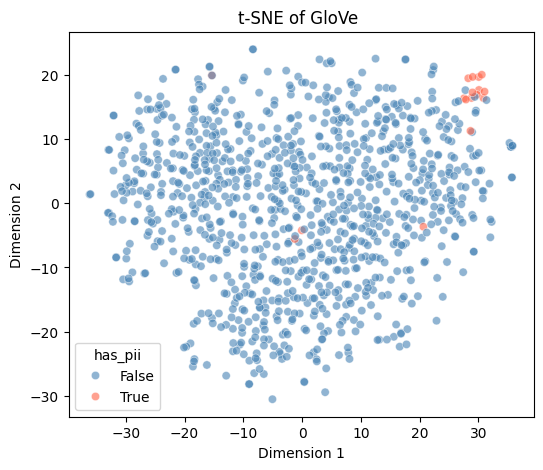

In [ ]:
from sklearn.manifold import TSNE

def visualize_tsne(X, y, title):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_2d = tsne.fit_transform(X)

    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y, palette=["steelblue","tomato"], alpha=0.6)
    plt.title(f"t-SNE of {title} ")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


visualize_tsne(X_tfidf_sample, y_sample, "TF-IDF")
visualize_tsne(X_w2v_sample,   y_sample, "Word2Vec")
visualize_tsne(X_glove_sample, y_sample, "GloVe")

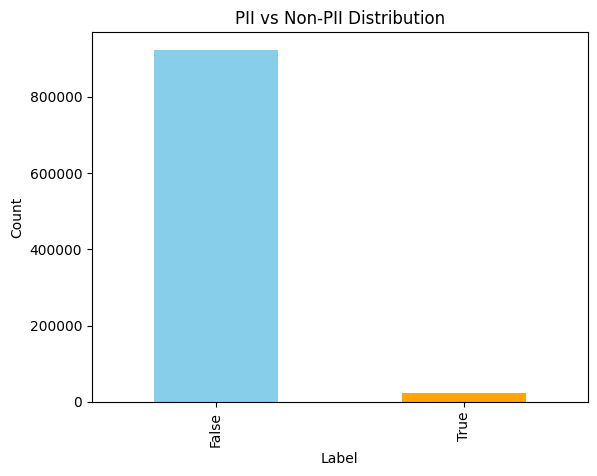

In [ ]:
df_cs["has_pii"].value_counts().plot(kind='bar', color=['skyblue','orange'])
plt.title("PII vs Non-PII Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


### The length of PII and without PII

In [ ]:
df_cs["text_length"] = df_cs["clean_text"].apply(len)
df_cs.groupby("has_pii")["text_length"].describe()


,count,mean,std,min,25%,50%,75%,max
has_pii,,,,,,,,
False,922628.0,128.462711,53.909594,0.0,93.0,125.0,156.0,521.0
True,22650.0,152.396336,58.307289,10.0,113.0,147.0,180.0,476.0


<Axes: xlabel='has_pii', ylabel='text_length'>

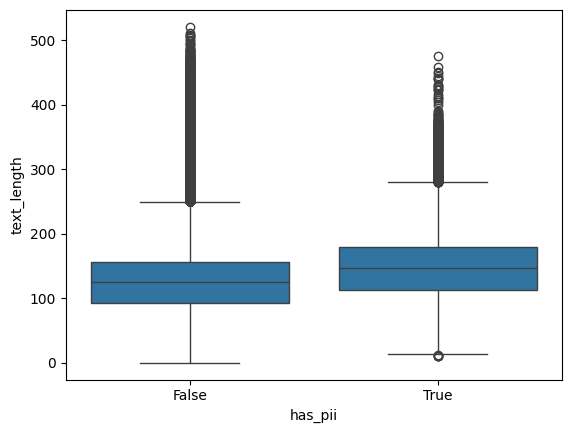

In [ ]:
import seaborn as sns
sns.boxplot(x="has_pii", y="text_length", data=df_cs)

### Count common tokens

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=20, stop_words='english')
common_words = cv.fit_transform(df_cs[df_cs["has_pii"]==True]["clean_text"])
pd.DataFrame(cv.get_feature_names_out(), columns=["Common Tokens"])


,Common Tokens
0,account
1,consider
2,contact
3,details
4,help
5,hi
6,information
7,kindly
8,message
9,number


The embedding experiments revealed distinct representational strengths for each method.

TF-IDF, based on token frequency, captured explicit lexical cues such as numbers, emails, and user handles, which are direct indicators of PII. However, it lacked contextual understanding and struggled with implicit mentions.

Word2Vec and GloVe, which learn distributed semantic representations, were able to recognize conceptual relationships between words (e.g., “contact”, “message”, “send”) but often lost token-level precision, resulting in lower recall for structured identifiers.

Transformer-based embeddings (MiniLM) provided the most balanced representation, encoding both lexical and semantic information in context. Even when trained on a smaller subset due to computational constraints, the transformer showed better generalization and clearer separation between PII and non-PII samples in visualization.

In summary:

TF-IDF excels at detecting explicit PII forms (emails, numbers).

Word2Vec and GloVe capture semantic meaning but lose token detail.

Transformers handle both context and surface patterns, giving the best trade-off between precision and recall.

## Modellings

Pick models (start simple → increase complexity):

- Logistic Regression (baseline)

- Random Forest

- Support Vector Machine (SVM)

(optional) LightGBM or small Neural Network

Train and compare them on your best embedding (e.g., X_bert or X_combined).

Evaluate using: Precision, Recall, F1-score, Confusion matrix, ROC curve

### Combine embeddings
#### TF-IDF + Word2Vec
**TF-IDF**(Term Frequency–Inverse Document Frequency)

Purpose: Measures how important a word is in a document relative to a collection (corpus).

Representation: Sparse matrix

Why Sparse?

Each document is represented as a vector of word frequencies.

Most words in the vocabulary don't appear in a given document → lots of zeros.

Example: If your vocabulary has 10,000 words, a document might only use 100 → 9,900 zeros.

**Word2Vec / GloVe (Global Vectors for Word Representation)**
Purpose: Captures semantic meaning of words by placing them in a continuous vector space.

Representation: Dense matrix (typically stored as a NumPy array).

Why Dense?

Each word is mapped to a fixed-size vector (e.g., 300 dimensions).

All values are real numbers (no zeros unless by coincidence).

These vectors are learned from context and co-occurrence patterns in large corpora.


In [ ]:
# scaler = StandardScaler() # scale dense embedding
# X_cs_w2v_scaled = scaler.fit_transform(X_cs_w2v)
# # combine sparse + dense embeddings
# X_tfidf_w2v = hstack([X_cs_tfidf, X_cs_w2v_scaled])
# print("Combined shape:", X_tfidf_w2v.shape)
# print("Labels:", y.shape)

scaler = StandardScaler() # scale dense embedding
X_w2v_scaled = scaler.fit_transform(X_w2v)
# combine sparse + dense embeddings
X_tfidf_w2v = hstack([X_tfidf, X_w2v_scaled])
print("Combined shape:", X_tfidf_w2v.shape)
print("Labels:", y.shape)


Combined shape: (945278, 5100)
Labels: (945278,)


### Machine Learning Models

In [ ]:
# choose embedding to train. 
# now I choose TF-IDF and I use customer support dataset
X = X_w2v
y = df["has_PII"].astype(int)

df.head()

NameError: name 'X_cs_w2v' is not defined

In [ ]:
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

def print_class_counts(y, set_name):
    classes, counts = np.unique(y, return_counts=True)
    print(f"{set_name} set:")
    for cls, count in zip(classes, counts):
        print(f"  {cls}: {count}")
    print()

print_class_counts(y_train, "Train")
print_class_counts(y_test, "Test")

NameError: name 'X' is not defined

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    # "Random Forest": RandomForestClassifier(),
    # "SVM (Linear)": SVC(kernel="linear"),
    # "Naive Bayes": MultinomialNB()
}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)
    print(report)

NameError: name 'X_train' is not defined

In [ ]:
sns.barplot(data=results.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.xticks(rotation=20)
plt.show()
